# BM25 vs Dense 임베딩 기반 검색과 RRF 결합 성능 비교
> 서로 다른 검색방법의 결과가 상이할때 유용한 방법이다.

Reciprocal Rank Fusion(RRF)은 **여러 검색 결과의 순위를 합쳐서 하나의 최종 순위를 만드는 방법**이다.  
예를 들어, 키워드 검색 결과와 벡터 검색 결과처럼 서로 다른 방식으로 나온 문서 리스트가 있을 때, 각 문서가 각 리스트에서 몇 번째에 있는지(순위)를 이용해 점수를 매긴다.  

$$
\text{score}(d) = \sum_{q} \frac{1}{k + \text{rank}(q, d)}
$$

- $d$: 문서  
- $q$: 각 검색 결과 집합  
- $\text{rank}(q, d)$: 검색 결과 $q$에서 문서 $d$의 순위(1부터 시작)  
- $k$: 보통 60 정도로 쓰는 상수

즉, **여러 검색 결과에서 상위에 자주 등장하는 문서일수록 점수가 높아지고, 최종 순위에서 위로 올라간다**.  
이 방식은 각 검색 결과의 점수 범위가 달라도 상관없이, 순위만으로 융합하므로 간단하게 적용할 수 있다.

In [1]:
%pip install -Uq python-dotenv langchain langchain-openai langchain-pinecone kiwipiepy rank_bm25 scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [2]:
from dotenv import load_dotenv
import os

load_dotenv()
os.environ['LANGSMITH_TRACING'] = 'true'
os.environ['LANGSMITH_ENDPOINT'] = 'https://api.smith.langchain.com'
os.environ['LANGSMITH_API_KEY'] = os.getenv('langsmith_key')
os.environ['LANGSMITH_PROJECT'] = 'skn23-langchain'
os.environ['OPENAI_API_KEY'] = os.getenv("openai_key")
os.environ['PINECONE_API_KEY'] = os.getenv("pinecone_key")

## 데이터 준비

In [3]:
import pandas as pd

documents_df = pd.read_csv('documents.csv')
queries_df = pd.read_csv('queries.csv')

## BM25

In [4]:
# BM25 키워드 검색 모델
# - 문서를 토큰화해서 BM25모델 생성
# - 검색어도 동일하게 토큰화한 이후 BM25 검색

from rank_bm25 import BM25Okapi
from kiwipiepy import Kiwi

kiwi = Kiwi()

def kiwi_tokenize(doc):
    return [token.form for token in kiwi.tokenize(doc)]

tokenized_docs = [kiwi_tokenize(doc) for doc in documents_df['content']]
bm25 = BM25Okapi(tokenized_docs)

def bm25_search(query, top_k=5):
    query_tokens = kiwi_tokenize(query)
    # print(query_tokens)
    scores = bm25.get_scores(query_tokens) # 30개의 문서에 대한 bm25 점수
    # print(scores)

    ranked_idx = sorted(range(len(scores)), key=lambda i: scores[i], reverse=True)
    retrieved_docs = [documents_df['doc_id'].iloc[i] for i in ranked_idx[:top_k]]
    return retrieved_docs

bm25_search('제주도 관광 명소')

['D1', 'D2', 'D3', 'D4', 'D5']

## 벡터 서치

In [5]:
from langchain_openai import OpenAIEmbeddings
from langchain_pinecone import PineconeVectorStore

embedding_model = OpenAIEmbeddings()
vector_store = PineconeVectorStore(
    index_name='ir',
    embedding=embedding_model
 )

c:\Users\Playdata\nlp\nlp_venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 검색성능 평가

**평가지표 설명**

* **Precision\@k**: 상위 k개의 검색 결과 중에 진짜 필요한 문서가 얼마나 있는지를 측정한다.
  - 예컨대 k=5일 때, 결과 5개 중 관련 문서가 2개면 Precision\@5 = 2/5 = 0.4다.

* **Recall\@k**: 전체 관련 문서 중에서 상위 k개 안에 얼마나 많이 들어왔는지를 본다.
  - 예컨대 전체 관련 문서가 4개이고, 그중 3개가 상위 5개 안에 들어오면 Recall\@5 = 3/4 = 0.75다.


* **MRR (Mean Reciprocal Rank)**:
  사용자가 제시한 여러 질의에서, 각 질의별로 “첫 번째 관련 문서”가 나온 순위의 역수를 구한 뒤 평균낸 것이다.
  **예시**

  * 질의 A: 첫 관련 문서가 2위 → RR = 1/2 = 0.5
  * 질의 B: 첫 관련 문서가 3위 → RR = 1/3 ≈ 0.333
  * 질의 C: 첫 관련 문서가 1위 → RR = 1/1 = 1
  * 이 세 질의의 MRR = (0.5 + 0.333 + 1) / 3 ≈ 0.611

* **AP (Average Precision)**:
  한 질의 결과 리스트를 순서대로 훑어가며, 관련 문서를 만날 때마다 그 시점까지의 Precision을 계산한 뒤, 관련 문서 개수로 나눈 값이다.
  **예시** (관련 문서 3개가 있고, 순위 2, 4, 5위에 위치한 경우)

  1. 2위에서 첫 관련 문서 발견 → Precision\@2 = 1/2 = 0.50
  2. 4위에서 두 번째 관련 문서 발견 → Precision\@4 = 2/4 = 0.50
  3. 5위에서 세 번째 관련 문서 발견 → Precision\@5 = 3/5 = 0.60
     AP = (0.50 + 0.50 + 0.60) / 3 ≈ 0.533

In [6]:
import numpy as np

# 참조문서 답안 파싱
def parse_relevant(relevant_str) -> dict[str, int]:
    """
    relevant_str = 'D1=3;D4=1;D30=1' -> {'D1': 3, 'D4': 1, 'D30': 1}
    """
    pairs = relevant_str.split(';')
    rel_dict = {}
    for pair in pairs:
        doc_id, grade = pair.split('=')
        rel_dict[doc_id] = int(grade)
    return rel_dict


# 평가지표 계산
def compute_metrics(predicted, relevant_dict, k=5) -> tuple[float, float, float, float]:
    # Precision@k
    hits = sum([1 for doc in predicted[:k] if doc in relevant_dict])
    precision = hits / k

    # Recall@k
    total_relevant = len(relevant_dict) # {'D1': 3, 'D12': 2, ...}
    recall = hits / total_relevant if total_relevant > 0 else 0

    # MRR 예측치중 첫 관련문서 순위점수
    rr = 0
    for idx, doc in enumerate(predicted):
        if doc in relevant_dict:
            rr = 1 / (idx + 1)
            break

    # AP(MAP를 위한 계산)
    num_correct = 0
    precisions = []
    for idx, doc in enumerate(predicted[:k]):
        if doc in relevant_dict:
            num_correct += 1
            precisions.append(num_correct / (idx + 1))
    ap = np.mean(precisions) if precisions else 0
    return precision, recall, rr, ap


# 평가함수
def evaluate_all(method_results, queries_df, k=5):
    prec_list, rec_list, rr_list, ap_list = [], [], [], []

    for idx, row in queries_df.iterrows():
        qid = row['query_id']
        relevant_dict = parse_relevant(row['relevant_doc_ids'])
        predicted = method_results[qid]
        p, r, rr, ap = compute_metrics(predicted, relevant_dict, k)
        prec_list.append(p)
        rec_list.append(r)
        rr_list.append(rr)
        ap_list.append(ap)

    return {
        'P@k': np.mean(prec_list),
        'R@k': np.mean(rec_list),
        'MRR': np.mean(rr_list),
        'MAP': np.mean(ap_list),
    }


## 06.BM25와 Dense 결과의 RRF 결합

> bm25와 dense 검색의 결과가 상이할대 rrf는 빛을 발한다.

RRF(Reciprocal Rank Fusion)는 서로 다른 검색 기법의 결과를 하나로 합쳐 더 안정적이고 정확한 순위를 만들어 내는 간단한 랭크 결합 기법이다.

1. 여러 검색 결과 리스트(예: BM25, Dense)에서 **문서의 순위(rank)** 를 이용해 점수를 계산한다.
2. 각 리스트별로, 문서가 n위에 있을 때 주어지는 점수는
   $\displaystyle \frac{1}{k + n}$
   형태이다. 여기서 k는 보통 60처럼 비교적 큰 상수로, 순위 차이에 따른 점수 차이를 완만하게 만들어 준다.
3. 두 개 이상의 리스트에서 **나온 점수를 모두 더해** 최종 RRF-점수를 구한다.
4. 최종 점수가 높은 문서일수록 “여러 기법에서 꾸준히 상위권” 에 올랐다는 뜻이므로, 가장 관련성이 높다고 판단된다.

예를 들어, 문서 A가

* BM25 결과에서 2위 → 점수 1/(60+2)
* Dense 결과에서 5위 → 점수 1/(60+5)
  를 받았다면,

$$
\text{RRF-점수}(A) = \frac{1}{62} + \frac{1}{65}
$$

가 되어, 두 기법에서 모두 좋은 순위를 받은 문서 A가 최종적으로 높은 순위에 오르게 된다.

이처럼 RRF는 각 검색 기법의 강점을 살려 **서로 다른 결과를 보완**하며, 한쪽에서만 높은 점수를 받은 노이즈 문서를 걸러내고, 여러 기법에서 상위권에 오른 핵심 문서를 잘 찾아준다.


In [ ]:
# Dense(Vector) 검색 결과 (top-20)을 쿼리별로 수집
dense_results = {}
for idx, row in queries_df.iterrows():
    qid = row['query_id']
    query_text = row['query_text']
    docs = vector_store.similarity_search(query_text, k=20)
    dense_results[qid] = [doc.metadata['doc_id'] for doc in docs]
print(dense_results)

{'Q1': ['D12', 'D1', 'D8', 'D26', 'D17', 'D15', 'D10', 'D9', 'D11', 'D14', 'D25', 'D30', 'D13', 'D7', 'D5', 'D19', 'D2', 'D27', 'D4', 'D3'], 'Q2': ['D13', 'D2', 'D16', 'D12', 'D5', 'D1', 'D11', 'D15', 'D3', 'D9', 'D4', 'D8', 'D10', 'D19', 'D6', 'D30', 'D26', 'D17', 'D18', 'D20'], 'Q3': ['D3', 'D9', 'D17', 'D15', 'D12', 'D1', 'D10', 'D4', 'D2', 'D5', 'D16', 'D26', 'D25', 'D8', 'D18', 'D21', 'D11', 'D29', 'D7', 'D13'], 'Q4': ['D4', 'D5', 'D1', 'D9', 'D2', 'D10', 'D3', 'D17', 'D15', 'D12', 'D16', 'D11', 'D25', 'D18', 'D26', 'D8', 'D27', 'D28', 'D23', 'D7'], 'Q5': ['D5', 'D4', 'D15', 'D2', 'D16', 'D23', 'D11', 'D7', 'D26', 'D1', 'D30', 'D12', 'D25', 'D28', 'D3', 'D10', 'D9', 'D20', 'D14', 'D17'], 'Q6': ['D6', 'D25', 'D26', 'D17', 'D1', 'D14', 'D10', 'D18', 'D4', 'D13', 'D12', 'D3', 'D2', 'D7', 'D15', 'D28', 'D8', 'D11', 'D9', 'D23'], 'Q7': ['D25', 'D7', 'D14', 'D26', 'D10', 'D1', 'D12', 'D17', 'D4', 'D5', 'D11', 'D29', 'D15', 'D16', 'D23', 'D9', 'D30', 'D3', 'D2', 'D18'], 'Q8': ['D8', 'D12

In [9]:
# BM25 검색 결과 (top-20)을 쿼리별로 수집
bm25_results = {}
for idx, row in queries_df.iterrows():  # 쿼리 데이터프레임을 한 줄씩 순회
    qid = row['query_id']
    query_text = row['query_text']
    bm25_results[qid] = bm25_search(query_text, top_k=20)  # qid키로 top-20 검색 결과 저장
bm25_results

{'Q1': ['D1',
  'D2',
  'D3',
  'D4',
  'D5',
  'D6',
  'D7',
  'D8',
  'D9',
  'D10',
  'D11',
  'D12',
  'D13',
  'D14',
  'D15',
  'D16',
  'D17',
  'D18',
  'D19',
  'D20'],
 'Q2': ['D13',
  'D2',
  'D1',
  'D3',
  'D4',
  'D5',
  'D6',
  'D7',
  'D8',
  'D9',
  'D10',
  'D11',
  'D12',
  'D14',
  'D15',
  'D16',
  'D17',
  'D18',
  'D19',
  'D20'],
 'Q3': ['D2',
  'D21',
  'D14',
  'D11',
  'D28',
  'D29',
  'D23',
  'D10',
  'D24',
  'D1',
  'D4',
  'D9',
  'D3',
  'D5',
  'D6',
  'D7',
  'D8',
  'D12',
  'D13',
  'D15'],
 'Q4': ['D4',
  'D9',
  'D1',
  'D30',
  'D5',
  'D3',
  'D22',
  'D15',
  'D2',
  'D6',
  'D7',
  'D8',
  'D10',
  'D11',
  'D12',
  'D13',
  'D14',
  'D16',
  'D17',
  'D18'],
 'Q5': ['D5',
  'D18',
  'D19',
  'D23',
  'D15',
  'D13',
  'D28',
  'D12',
  'D4',
  'D11',
  'D7',
  'D14',
  'D26',
  'D22',
  'D24',
  'D3',
  'D6',
  'D29',
  'D21',
  'D9'],
 'Q6': ['D6',
  'D27',
  'D17',
  'D25',
  'D3',
  'D14',
  'D8',
  'D15',
  'D10',
  'D9',
  'D2',
  'D1',

In [ ]:
# rrf 결합함수
def rrf_rank(bm25_list, dense_list, k=60):
    """
    k는 역수값 안정을 위한 상수
    """
    candidate_scores = {}  # 문서별 RRF 점수 누적 dict
    for rank, doc in enumerate(bm25_list, 1):  # BM25 순위를 1부터 부여
        candidate_scores[doc] = candidate_scores.get(doc, 0) + 1 / (k + rank)  # RRF점수 누적계산
    for rank, doc in enumerate(dense_list, 1):
        candidate_scores[doc] = candidate_scores.get(doc, 0) + 1 / (k + rank)

    # 점수 내림차순 정렬
    ranked = sorted(candidate_scores.items(), key=lambda item:item[1], reverse=True)
    return [doc for doc, _ in ranked]  # doc_id 순서만 반환


rrf_results = {}  # qid별 RRF 결합 결과 저장
top_k = 5

# 쿼리별 결합 수행
for idx, row in queries_df.iterrows():
    qid = row['query_id']
    query_text = row['query_text']
    bm25_top20 = bm25_results[qid]
    dense_top20 = dense_results[qid]
    rrf_list = rrf_rank(bm25_top20, dense_top20)
    rrf_results[qid] = rrf_list[:top_k]  # 상위 5개 TOP_k만 결과 저장
rrf_results

{'Q1': ['D1', 'D8', 'D12', 'D10', 'D9'],
 'Q2': ['D13', 'D2', 'D1', 'D5', 'D3'],
 'Q3': ['D2', 'D3', 'D9', 'D10', 'D1'],
 'Q4': ['D4', 'D9', 'D1', 'D5', 'D3'],
 'Q5': ['D5', 'D15', 'D23', 'D4', 'D11'],
 'Q6': ['D6', 'D25', 'D17', 'D14', 'D10'],
 'Q7': ['D25', 'D7', 'D14', 'D10', 'D17'],
 'Q8': ['D8', 'D12', 'D18', 'D30', 'D4'],
 'Q9': ['D9', 'D1', 'D3', 'D2', 'D15'],
 'Q10': ['D10', 'D3', 'D4', 'D17', 'D1'],
 'Q11': ['D11', 'D12', 'D26', 'D22', 'D28'],
 'Q12': ['D12', 'D8', 'D1', 'D9', 'D2'],
 'Q13': ['D13', 'D2', 'D26', 'D11', 'D3'],
 'Q14': ['D14', 'D7', 'D26', 'D25', 'D1'],
 'Q15': ['D15', 'D9', 'D1', 'D4', 'D3'],
 'Q16': ['D16', 'D9', 'D15', 'D1', 'D5'],
 'Q17': ['D17', 'D25', 'D3', 'D10', 'D9'],
 'Q18': ['D18', 'D4', 'D28', 'D5', 'D1'],
 'Q19': ['D19', 'D24', 'D23', 'D22', 'D29'],
 'Q20': ['D20', 'D4', 'D10', 'D27', 'D5'],
 'Q21': ['D21', 'D18', 'D25', 'D7', 'D11'],
 'Q22': ['D22', 'D23', 'D24', 'D19', 'D7'],
 'Q23': ['D23', 'D24', 'D26', 'D22', 'D19'],
 'Q24': ['D24', 'D23', 'D22

In [11]:
# rrf 검색결과
import pandas as pd
pd.set_option('display.max_columns', None)
pd.DataFrame(rrf_results, columns=rrf_results.keys())

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12,Q13,Q14,Q15,Q16,Q17,Q18,Q19,Q20,Q21,Q22,Q23,Q24,Q25,Q26,Q27,Q28,Q29,Q30
0,D1,D13,D2,D4,D5,D6,D25,D8,D9,D10,D11,D12,D13,D14,D15,D16,D17,D18,D19,D20,D21,D22,D23,D24,D25,D26,D27,D28,D29,D4
1,D8,D2,D3,D9,D15,D25,D7,D12,D1,D3,D12,D8,D2,D7,D9,D9,D25,D4,D24,D4,D18,D23,D24,D23,D17,D14,D30,D30,D30,D30
2,D12,D1,D9,D1,D23,D17,D14,D18,D3,D4,D26,D1,D26,D26,D1,D15,D3,D28,D23,D10,D25,D24,D26,D22,D7,D7,D5,D27,D22,D7
3,D10,D5,D10,D5,D4,D14,D10,D30,D2,D17,D22,D9,D11,D25,D4,D1,D10,D5,D22,D27,D7,D19,D22,D19,D14,D29,D4,D7,D28,D25
4,D9,D3,D1,D3,D11,D10,D17,D4,D15,D1,D28,D2,D3,D1,D3,D5,D9,D1,D29,D5,D11,D7,D19,D21,D10,D28,D3,D14,D24,D14


In [12]:
# bm25 검색결과
import pandas as pd
pd.set_option('display.max_columns', None)
pd.DataFrame(bm25_results, columns=bm25_results.keys())

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12,Q13,Q14,Q15,Q16,Q17,Q18,Q19,Q20,Q21,Q22,Q23,Q24,Q25,Q26,Q27,Q28,Q29,Q30
0,D1,D13,D2,D4,D5,D6,D27,D8,D9,D10,D11,D12,D13,D14,D9,D16,D17,D18,D19,D20,D21,D22,D23,D24,D25,D26,D27,D28,D29,D30
1,D2,D2,D21,D9,D18,D27,D25,D18,D27,D3,D4,D8,D14,D7,D15,D15,D25,D4,D18,D27,D19,D7,D26,D23,D9,D14,D30,D27,D12,D4
2,D3,D1,D14,D1,D19,D17,D7,D30,D1,D9,D14,D9,D26,D25,D26,D9,D6,D28,D14,D10,D25,D23,D24,D22,D17,D7,D1,D30,D22,D29
3,D4,D3,D11,D30,D23,D25,D14,D12,D2,D17,D28,D27,D2,D27,D14,D29,D3,D5,D24,D3,D2,D19,D22,D19,D3,D5,D2,D1,D28,D25
4,D5,D4,D28,D5,D15,D3,D9,D29,D3,D25,D26,D5,D3,D26,D1,D8,D10,D7,D29,D4,D11,D18,D19,D3,D8,D29,D3,D2,D30,D14
5,D6,D5,D29,D3,D13,D14,D17,D1,D4,D2,D12,D13,D9,D1,D2,D1,D9,D12,D22,D1,D28,D24,D4,D9,D15,D19,D4,D3,D18,D7
6,D7,D6,D23,D22,D28,D8,D10,D2,D5,D4,D3,D15,D23,D2,D3,D30,D15,D19,D23,D2,D5,D1,D11,D30,D7,D22,D5,D4,D4,D21
7,D8,D7,D10,D15,D12,D15,D15,D3,D6,D1,D23,D24,D11,D3,D4,D5,D2,D1,D9,D5,D7,D2,D14,D21,D14,D15,D6,D5,D24,D3
8,D9,D8,D24,D2,D4,D10,D2,D4,D7,D6,D22,D1,D30,D4,D5,D3,D1,D2,D11,D6,D12,D3,D25,D2,D6,D4,D7,D6,D3,D26
9,D10,D9,D1,D6,D11,D9,D3,D5,D8,D15,D24,D2,D25,D5,D6,D19,D4,D3,D3,D7,D18,D4,D21,D8,D10,D18,D8,D7,D15,D15


In [13]:
# dense 검색결과
import pandas as pd
pd.set_option('display.max_columns', None)
pd.DataFrame(dense_results, columns=dense_results.keys())

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12,Q13,Q14,Q15,Q16,Q17,Q18,Q19,Q20,Q21,Q22,Q23,Q24,Q25,Q26,Q27,Q28,Q29,Q30
0,D12,D13,D3,D4,D5,D6,D25,D8,D9,D10,D11,D12,D13,D14,D15,D16,D17,D18,D19,D20,D21,D22,D23,D24,D25,D26,D27,D28,D29,D4
1,D1,D2,D9,D5,D4,D25,D7,D12,D15,D4,D2,D1,D2,D26,D16,D9,D25,D4,D23,D18,D23,D23,D24,D23,D7,D14,D29,D29,D30,D7
2,D8,D16,D17,D1,D15,D26,D14,D15,D1,D1,D13,D8,D11,D7,D9,D2,D3,D26,D20,D12,D18,D24,D22,D22,D17,D7,D30,D30,D27,D30
3,D26,D12,D15,D9,D2,D17,D26,D26,D3,D3,D1,D10,D16,D25,D4,D4,D10,D20,D24,D16,D26,D20,D20,D19,D14,D28,D26,D26,D7,D25
4,D17,D5,D12,D2,D16,D1,D10,D4,D12,D5,D12,D4,D26,D6,D1,D5,D1,D10,D22,D4,D15,D19,D26,D20,D26,D29,D28,D27,D26,D5
5,D15,D1,D1,D10,D23,D14,D1,D10,D16,D17,D16,D2,D12,D29,D12,D1,D9,D21,D28,D19,D30,D30,D15,D26,D23,D25,D18,D19,D24,D14
6,D10,D11,D10,D3,D11,D10,D12,D17,D8,D15,D22,D17,D23,D1,D7,D12,D5,D28,D29,D22,D10,D26,D19,D18,D10,D18,D17,D14,D20,D1
7,D9,D15,D4,D17,D7,D18,D17,D3,D17,D12,D26,D9,D3,D18,D3,D23,D12,D15,D27,D5,D17,D18,D7,D21,D1,D27,D5,D18,D14,D26
8,D11,D3,D2,D15,D26,D4,D4,D1,D10,D9,D19,D3,D1,D12,D5,D15,D26,D1,D16,D24,D14,D7,D16,D16,D6,D30,D19,D20,D22,D17
9,D14,D9,D5,D12,D1,D13,D5,D18,D2,D2,D3,D15,D18,D28,D11,D19,D7,D5,D11,D26,D7,D11,D18,D7,D4,D6,D20,D7,D28,D12


## 성능평가

In [14]:
bm25_results_5 = {qid: list[:5] for qid, list in bm25_results.items()}
dense_results_5 = {qid: list[:5] for qid, list in dense_results.items()}

bm25_metrics = evaluate_all(bm25_results_5, queries_df, k=5)
dense_metrics = evaluate_all(dense_results_5, queries_df, k=5)
rrf_metrics = evaluate_all(rrf_results, queries_df, k=5)

In [15]:
import pandas as pd
metrics_df = pd.DataFrame({
    'Metrics': ['P@5', 'R@5', 'MRR', 'MAP'],
    'BM25': [bm25_metrics['P@k'], bm25_metrics['R@k'], bm25_metrics['MRR'], bm25_metrics['MAP']],
    'Dense': [dense_metrics['P@k'], dense_metrics['R@k'], dense_metrics['MRR'], dense_metrics['MAP']],
    'RRF': [rrf_metrics['P@k'], rrf_metrics['R@k'], rrf_metrics['MRR'], rrf_metrics['MAP']]
})
metrics_df


,Metrics,BM25,Dense,RRF
0,P@5,0.233333,0.273333,0.260000
1,R@5,0.838889,0.950000,0.916667
2,MRR,0.900000,0.966667,0.966667
3,MAP,0.874444,0.930556,0.924074


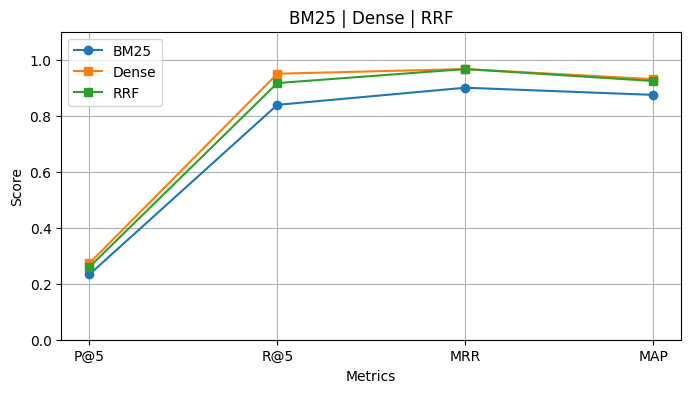

In [16]:
# 시각화
import matplotlib.pyplot as plt

metrics = ['P@5', 'R@5', 'MRR', 'MAP']
bm25_vals = [bm25_metrics['P@k'], bm25_metrics['R@k'], bm25_metrics['MRR'], bm25_metrics['MAP']]
dense_vals = [dense_metrics['P@k'], dense_metrics['R@k'], dense_metrics['MRR'], dense_metrics['MAP']]
rrf_vals = [rrf_metrics['P@k'], rrf_metrics['R@k'], rrf_metrics['MRR'], rrf_metrics['MAP']]

x = range(len(metrics))

plt.figure(figsize=(8, 4))
plt.plot(x, bm25_vals, marker='o', label='BM25')
plt.plot(x, dense_vals, marker='s', label='Dense')
plt.plot(x, rrf_vals, marker='s', label='RRF')
plt.xticks(x, metrics)
plt.ylim(0, 1.1)
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('BM25 | Dense | RRF')
plt.legend()
plt.grid()
plt.show()



### 지금 실험에서 Dense가 가장 높은 이유
##### 데이터셋 특성
- 쿼리: 자연어(의미 중심)
- 문서: 비교적 길고 서술형
- 정답 판단: 의미 유사성 중심
**Dense에게 매우 유리한 환경**

### RRF가 강해지는 조건
##### RRF는 이런 상황에서 좋다.
- BM25와 Dense가 서로 다른 문서를 잘 가져올 때
- Dense가 놓친 문서를 BM25가 보완해줄 때
- 쿼리가 짧고 키워드성이 강한 경우가 섞여 있을 때
**즉,두 모델의 오류 패턴이 다를 때**